Making a micrograd which is a mini version of Autograd

In [ ]:
!pip install matplotlib -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math


In [ ]:
def f(x):
  return 3*x**2 -4*x +5

In [ ]:
f(3.0)

20.0

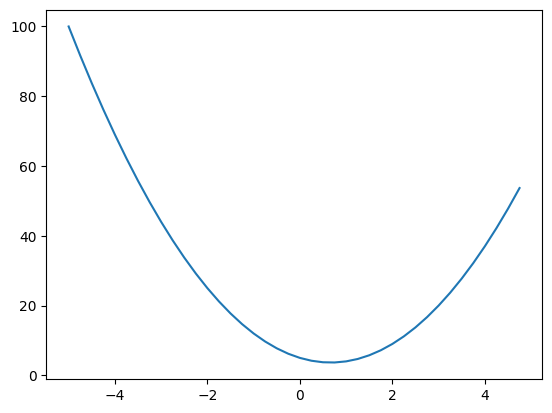

In [ ]:
xs = np.arange(-5,5,0.25)
ys =  f(xs)
plt.plot(xs,ys)

In [ ]:
class Value :
  def __init__(self,data,_children =(),_op ='',label = ''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._backward = lambda:None
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data ={self.data})"

  def __add__(self,other):
    other=  other if isinstance(other,Value) else Value(other)
    out = Value(self.data +other.data, (self ,other),'+')
    def _backward():
      self.grad += 1.0*out.grad
      other.grad +=  1.0*out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # other + self
        return self + other

  def __neg__(self):
    return self *-1

  def __sub__(self,other):
    return self +(-other)

  def __mul__(self,other):
    other=  other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self, other),'*')
    def _backward():
      self.grad += other.data*out.grad
      other.grad +=  self.data*out.grad
    out._backward = _backward
    return out

  def __rmul__(self,other):
    return self *other

  def __pow__(self,other):
    assert isinstance(other,(int,float))
    out = Value(self.data**other,(self,), f'**{other}')
    def _backward():
      self.grad += other*(self.data**(other-1)) *out.grad
    out._backward = _backward
    return out

  def __truediv__(self,other):
    return self*other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t,(self,),'tanh')
    def _backward():
      self.grad += (1-t**2)*out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),_op ='exp')
    def _backward():
      self.grad +=out.data *out.grad
    out._backward =_backward
    return out

  def backward(self):
    topo =[]
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

h = 0.00001
a = Value(2.0,label ='a')
b = Value(-3.0,label ='b')
c = Value(10,label='c')
e = a*b; e.label ='e'
d = e +c;d.label ='d'
f = Value(-2.0,label ='f')
L = d*f
L.label ='L'



In [ ]:
a= Value(5)
1*a

Value(data =5)

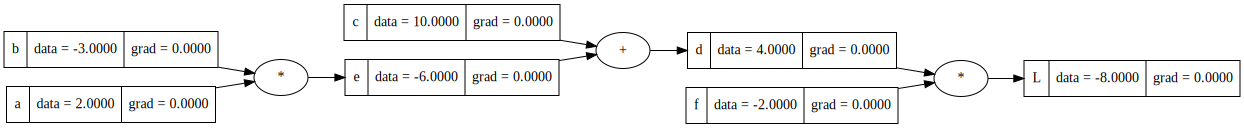

In [ ]:
from graphviz import Digraph
def trace(root):
  #build a set of all edges and nodes
  nodes , edges = set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes,edges

def draw_dot(root):

  dot = Digraph(format ='svg',graph_attr ={'rankdir':'LR'})

  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    #for any value in the graph create a recctangular{'record'} node for it
    dot.node(name=uid, label = "{%s |data = %.4f |grad = %.4f}"%(n.label,n.data,n.grad), shape = "record")
    if n._op:
      #if this value is the result of some operation create a node for it
      dot.node(name = uid+n._op,label = n._op)
      #and connect the node to this
      dot.edge(uid+n._op,uid)
  for n1,n2 in edges:
    #connect n1 to the operation of n2
    dot.edge(str(id(n1)) ,str(id(n2))+n2._op)

  return dot

draw_dot(L)

In [ ]:
L.grad =1.0

In [ ]:
x1,x2 =Value(2.0,label ='x1'),Value(0.0,label ='x2')
w1,w2 =Value(-3.0,label ='w1'),Value(1.0,label ='w2')

b= Value(6.8813735,label ='b')

x1w1 = x1*w1 ;x1w1.label = 'x1*w1'

x2w2 = x2*w2 ; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2 ;x1w1x2w2.label ='x1*w1 + x2*w2'

n = x1w1x2w2 +b; n.label ='n'

o = n.tanh(); o.label ='o'


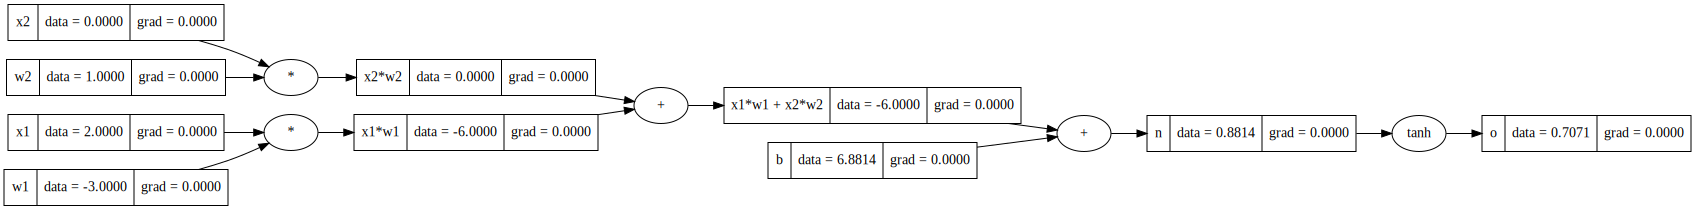

In [ ]:
draw_dot(o)

Topological sort


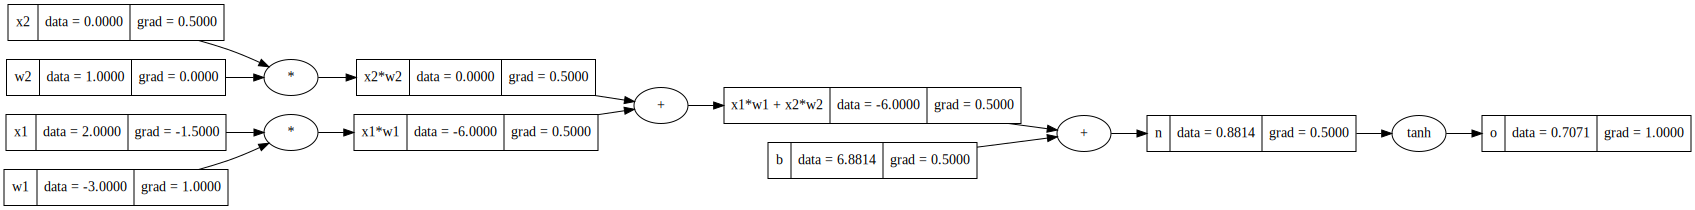

In [ ]:
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.881373]).double(); b.requires_grad = True

n= w1*x1 +w2*x2 +b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('=======')
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())

0.7071064519863152
x1 -1.500001396677975
x2 0.500000465559325
w1 1.00000093111865
w2 0.0


In [ ]:
import random
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w +[self.b]

class Layer:
  def __init__(self,nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) ==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin]+nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x =[2.0,3.0,-1.0]
n = MLP(3,[4,4,1])

n(x)

Value(data =-0.2770143614718539)

In [ ]:
len(n.parameters())

41

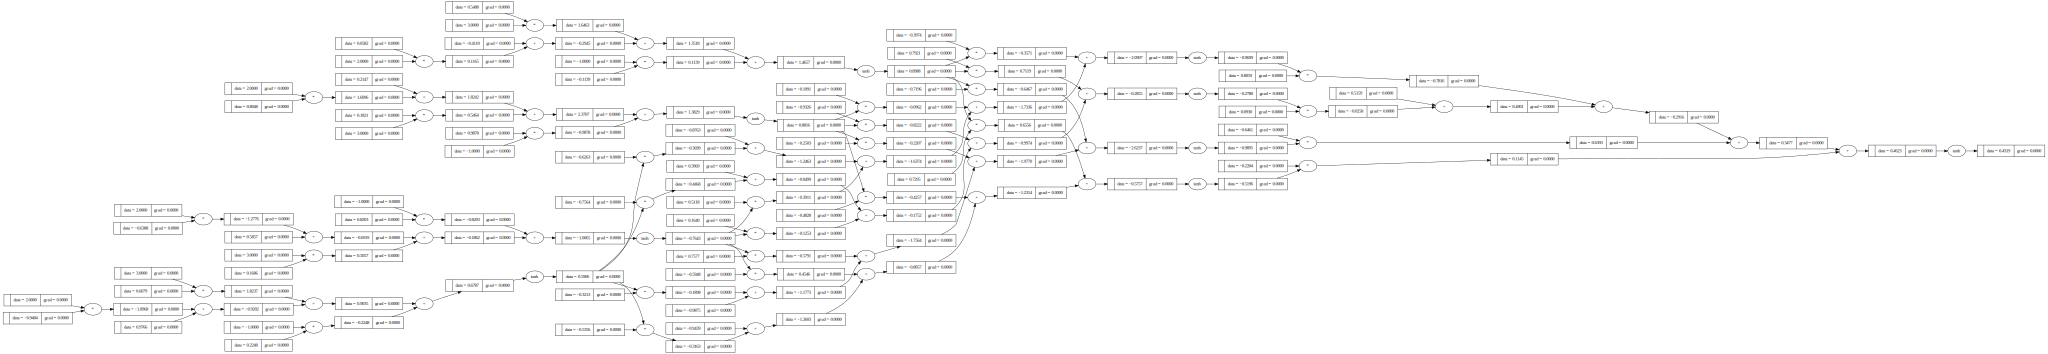

In [ ]:
draw_dot(n(x))

In [ ]:
xs = [[2.0,3.0,-1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0],
      ]
ys =[1.0,-1.0,-1.0,1.0]

y_pred = [n(x) for x in xs]
y_pred

[Value(data =-0.2770143614718539),
 Value(data =0.44994150797770993),
 Value(data =-0.19872741254790047),
 Value(data =0.6269978448528706)]

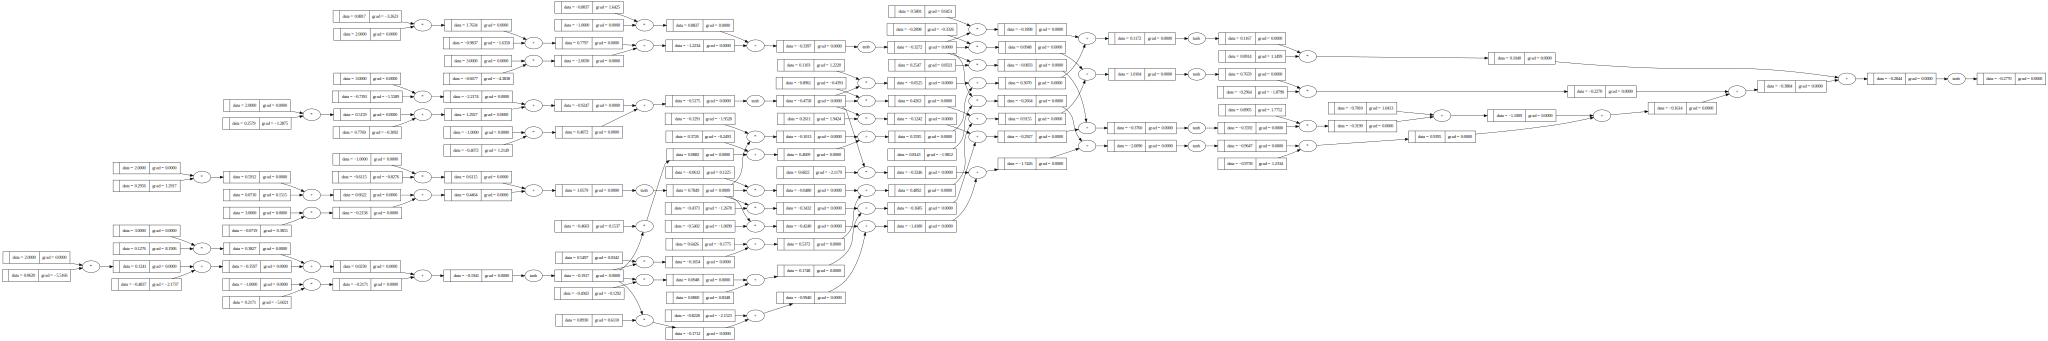

In [ ]:
draw_dot(n(x))

In [ ]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
loss

Value(data =4.514264423108628)

This is essentially the first neuron gradient calculation

In [ ]:
print(n.layers[0].neurons[0].w[0].grad)
loss.backward()
print(n.layers[0].neurons[0].w[0].grad)

0.0
-5.516639947301101


In [ ]:
print(n.layers[0].neurons[0].w[0].data)

0.06202636796615102


In [ ]:
for p in n.parameters():
  p.data += -0.01 *p.grad

In [ ]:
print(n.layers[0].neurons[0].w[0].data)

0.11719276743916203


Gradient descent I did 3 iterations

In [ ]:
y_pred = [n(x) for x in xs]
y_pred
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
loss

Value(data =0.6219310106309648)

In [ ]:
loss.backward()

In [ ]:
for p in n.parameters():
  p.data += -0.01 *p.grad

Fixing Bug and doing it ina loop

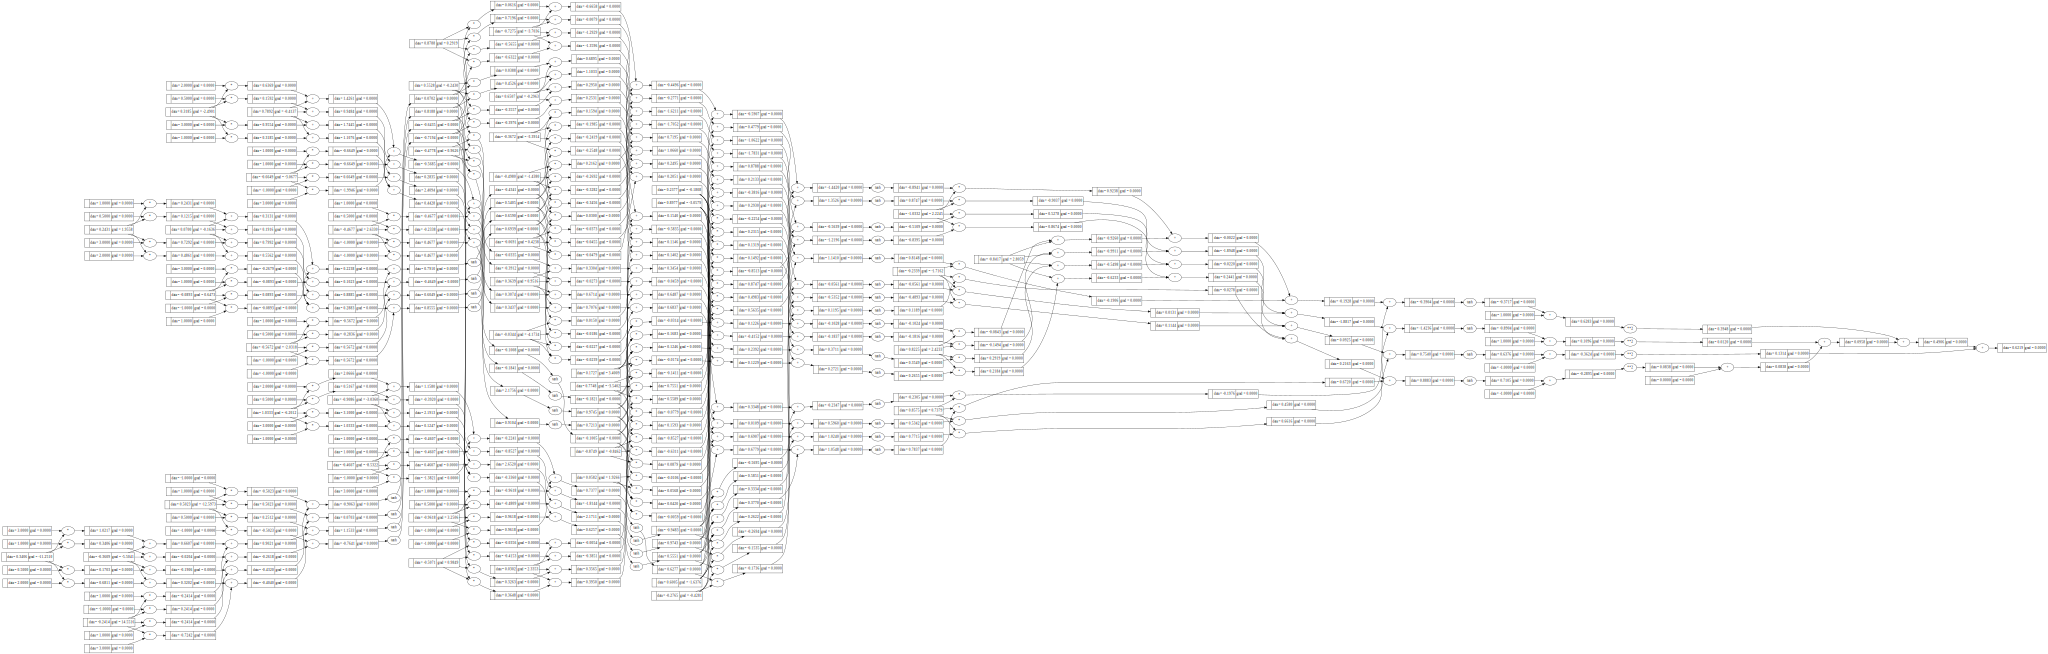

In [ ]:
draw_dot(loss)

In [ ]:
for j in range(20):
  y_pred = [n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt , yout in zip(ys,y_pred))

  #backward_pass
  #zero_grad
  for p in n.parameters():
    p.grad = 0.0

  #this works because loss is a value object
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.05*p.grad

  print(j,loss.data)

0 0.03383229913282994
1 0.032258487352657864
2 0.030814460914037556
3 0.02948515695759414
4 0.028257743479023323
5 0.027121220047947057
6 0.02606610192636638
7 0.025084167753623626
8 0.02416825623435027
9 0.02331210099466846
10 0.022510195449501412
11 0.021757681472541486
12 0.02105025709617679
13 0.02038409953850406
14 0.01975580066005866
15 0.01916231256522597
16 0.01860090153296224
17 0.01806910882467702
18 0.017564717200221666
19 0.01708572219515872


In [ ]:
y_pred

[Value(data =0.9407622328250154),
 Value(data =-0.9295182351440814),
 Value(data =-0.9347256053232539),
 Value(data =0.9340592435768257)]